In [1]:
import glob
import os

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import random
import subprocess
import tempfile
import typing
from os import path

import audiomentations as aug
import ffmpeg
import keras
import numpy as np
import soundfile as sf
from IPython import display
from keras import callbacks, layers, ops, saving
from matplotlib import pyplot as plt

In [2]:
# MUSDB18 dataset configuration
MUSDB_STREAMS = {"mixture": 0, "drums": 1, "bass": 2, "other": 3, "vocals": 4}
TARGET_INSTRUMENTS = {track: MUSDB_STREAMS[track] for track in ("vocals",)}
N_INSTRUMENTS = len(TARGET_INSTRUMENTS)
SOURCE_INSTRUMENTS = tuple(k for k in MUSDB_STREAMS if k != "mixture")

# Audio preprocessing parameters for Short-Time Fourier Transform (STFT)
N_SUBBANDS = 4  # Number of subbands into which frequencies are split
CHUNK_SIZE = 65024  # Number of amplitude samples per audio chunk (~4 seconds)
STFT_N_FFT = 2048  # FFT points used in STFT
STFT_HOP_LENGTH = 512  # Hop length for STFT

# Training hyperparameters
N_CHANNELS = 64  # Base channel count for the model
BATCH_SIZE = 3
ACCUMULATION_STEPS = 2
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * (ACCUMULATION_STEPS or 1)

# Paths
TMP_DIR = path.expanduser("~/.keras/tmp")
DATASET_DIR = path.expanduser("~/.keras/datasets")
MODEL_PATH = path.join(TMP_DIR, f"model_{keras.backend.backend()}.keras")
CSV_LOG_PATH = path.join(TMP_DIR, f"training_{keras.backend.backend()}.csv")
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(TMP_DIR, exist_ok=True)

# Set random seed for reproducibility
keras.utils.set_random_seed(21)

2025-11-14 09:16:44.247460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763108204.259473   26091 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763108204.263208   26091 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763108204.273986   26091 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763108204.273996   26091 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763108204.273998   26091 computation_placer.cc:177] computation placer alr

In [3]:
def download_musdb18(out_dir=None):
    """Download and extract the MUSDB18 dataset, then convert .mp4 files to .wav files.

    MUSDB18 reference:
    Rafii, Z., Liutkus, A., Stöter, F.-R., Mimilakis, S. I., & Bittner, R. (2017).
    MUSDB18 - a corpus for music separation (1.0.0) [Data set]. Zenodo.
    """
    ffmpeg.init()
    from ffmpeg import FFMPEG_PATH

    # Create output directories
    os.makedirs((base := out_dir or tempfile.mkdtemp()), exist_ok=True)
    if path.exists((out_dir := path.join(base, "musdb18_wav"))):
        print("MUSDB18 dataset already downloaded")
        return out_dir

    # Download and extract the dataset
    download_dir = keras.utils.get_file(
        fname="musdb18",
        origin="https://zenodo.org/records/1117372/files/musdb18.zip",
        extract=True,
    )

    # ffmpeg command template: input, stream index, output
    ffmpeg_args = str(FFMPEG_PATH) + " -v error -i {} -map 0:{} -vn -ar 16000 {}"

    # Convert each mp4 file to multiple .wav files for each track
    for split in ("train", "test"):
        songs = os.listdir(path.join(download_dir, split))
        for i, song in enumerate(songs):
            if i % 10 == 0:
                print(f"{split.capitalize()}: {i}/{len(songs)} songs processed")

            mp4_path_orig = path.join(download_dir, split, song)
            mp4_path = path.join(tempfile.mkdtemp(), split, song.replace(" ", "_"))
            os.makedirs(path.dirname(mp4_path), exist_ok=True)
            os.rename(mp4_path_orig, mp4_path)

            wav_dir = path.join(out_dir, split, path.basename(mp4_path).split(".")[0])
            os.makedirs(wav_dir, exist_ok=True)

            for track in SOURCE_INSTRUMENTS:
                out_path = path.join(wav_dir, f"{track}.wav")
                stream_index = MUSDB_STREAMS[track]
                args = ffmpeg_args.format(mp4_path, stream_index, out_path).split()
                assert subprocess.run(args).returncode == 0, "ffmpeg conversion failed"
    return out_dir


# Download and prepare the MUSDB18 dataset
songs = download_musdb18(out_dir=DATASET_DIR)

4684228845/4684228845 ━━━━━━━━━━━━━━━━━━━━ 1075s 0us/step
Train: 0/100 songs processed
Train: 10/100 songs processed
Train: 20/100 songs processed
Train: 30/100 songs processed
Train: 40/100 songs processed
Train: 50/100 songs processed
Train: 60/100 songs processed
Train: 70/100 songs processed
Train: 80/100 songs processed
Train: 90/100 songs processed
Test: 0/50 songs processed
Test: 10/50 songs processed
Test: 20/50 songs processed
Test: 30/50 songs processed
Test: 40/50 songs processed


In [4]:
class Dataset(keras.utils.PyDataset):
    def __init__(
        self,
        songs,
        batch_size=BATCH_SIZE,
        chunk_size=CHUNK_SIZE,
        batches_per_epoch=1000 * ACCUMULATION_STEPS,
        augmentation=True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.augmentation = augmentation
        self.vocals_augmentations = [
            aug.PitchShift(min_semitones=-5, max_semitones=5, p=0.1),
            aug.SevenBandParametricEQ(-9, 9, p=0.25),
            aug.TanhDistortion(0.1, 0.7, p=0.1),
        ]
        self.other_augmentations = [
            aug.PitchShift(p=0.1),
            aug.AddGaussianNoise(p=0.1),
        ]
        self.songs = songs
        self.sizes = {song: self.get_track_set_size(song) for song in self.songs}
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.batches_per_epoch = batches_per_epoch

    def get_track_set_size(self, song: str):
        """Return the smallest track length in the given song directory."""
        sizes = [len(sf.read(p)[0]) for p in glob.glob(path.join(song, "*.wav"))]
        if max(sizes) != min(sizes):
            print(f"Warning: {song} has different track lengths")
        return min(sizes)

    def random_chunk_of_instrument_type(self, instrument: str):
        """Extract a random chunk for the specified instrument from a random song."""
        song, size = random.choice(list(self.sizes.items()))
        track = path.join(song, f"{instrument}.wav")

        if self.chunk_size <= size:
            start = np.random.randint(size - self.chunk_size + 1)
            audio = sf.read(track, self.chunk_size, start, dtype="float32")[0]
            audio_mono = np.mean(audio, axis=1)
        else:
            # If the track is shorter than chunk_size, pad the signal
            audio_mono = np.mean(sf.read(track, dtype="float32")[0], axis=1)
            audio_mono = np.pad(audio_mono, ((0, self.chunk_size - size),))

        # If the chunk is almost silent, retry
        if np.mean(np.abs(audio_mono)) < 0.01:
            return self.random_chunk_of_instrument_type(instrument)

        return self.data_augmentation(audio_mono, instrument)

    def data_augmentation(self, audio: np.ndarray, instrument: str):
        """Apply data augmentation to the audio chunk, if enabled."""

        def coin_flip(x, probability: float, fn: typing.Callable):
            return fn(x) if random.uniform(0, 1) < probability else x

        if self.augmentation:
            augmentations = (
                self.vocals_augmentations
                if instrument == "vocals"
                else self.other_augmentations
            )
            # Loudness augmentation
            audio *= np.random.uniform(0.5, 1.5, (len(audio),)).astype("float32")
            # Random reverse
            audio = coin_flip(audio, 0.1, lambda x: np.flip(x))
            # Random polarity inversion
            audio = coin_flip(audio, 0.5, lambda x: -x)
            # Apply selected augmentations
            for aug_ in augmentations:
                aug_.randomize_parameters(audio, sample_rate=16000)
                audio = aug_(audio, sample_rate=16000)
        return audio

    def random_mix_of_tracks(self) -> dict:
        """Create a random mix of instruments by summing their individual chunks."""
        tracks = {}
        for instrument in SOURCE_INSTRUMENTS:
            # Start with a single random chunk
            mixup = [self.random_chunk_of_instrument_type(instrument)]

            # Randomly add more chunks of the same instrument (mixup augmentation)
            if self.augmentation:
                for p in (0.2, 0.02):
                    if random.uniform(0, 1) < p:
                        mixup.append(self.random_chunk_of_instrument_type(instrument))

            tracks[instrument] = np.mean(mixup, axis=0, dtype="float32")
        return tracks

    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, idx):
        # Generate a batch of random mixtures
        batch = [self.random_mix_of_tracks() for _ in range(self.batch_size)]

        # Features: sum of all tracks
        batch_x = ops.sum(
            np.array([list(track_set.values()) for track_set in batch]), axis=1
        )

        # Labels: isolated target instruments (e.g., vocals)
        batch_y = np.array(
            [[track_set[t] for t in TARGET_INSTRUMENTS] for track_set in batch]
        )

        return batch_x, ops.convert_to_tensor(batch_y)


# Create train and validation datasets
train_ds = Dataset(glob.glob(path.join(songs, "train", "*")))
val_ds = Dataset(
    glob.glob(path.join(songs, "test", "*")),
    batches_per_epoch=int(0.1 * train_ds.batches_per_epoch),
    augmentation=False,
)

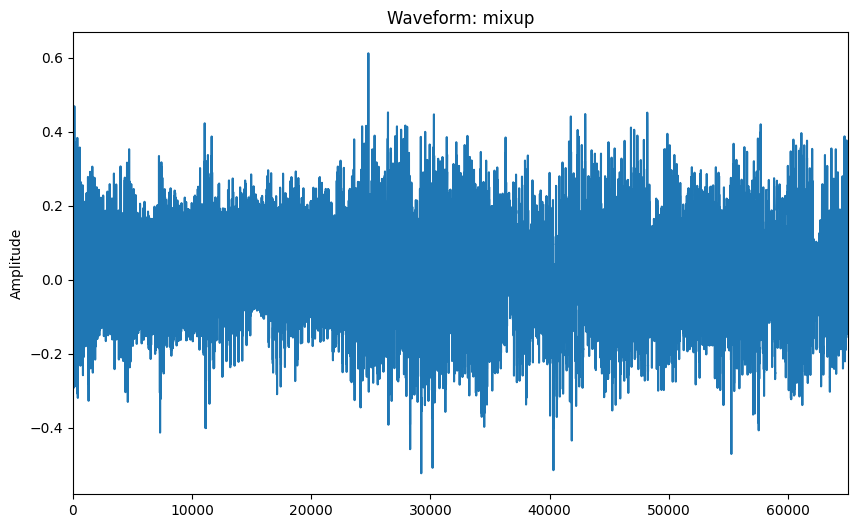

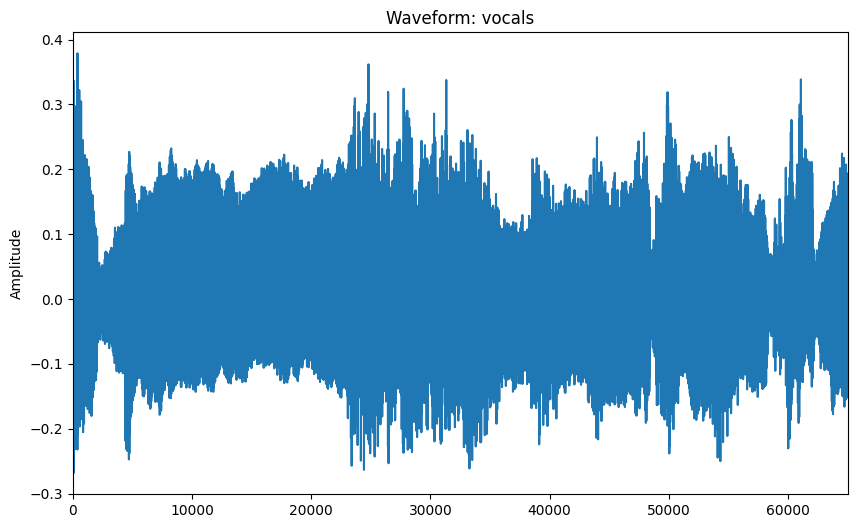

In [5]:
def visualize_audio_np(audio: np.ndarray, rate=16000, name="mixup"):
    """Plot and display an audio waveform and also produce an Audio widget."""
    plt.figure(figsize=(10, 6))
    plt.plot(audio)
    plt.title(f"Waveform: {name}")
    plt.xlim(0, len(audio))
    plt.ylabel("Amplitude")
    plt.show()
    # plt.savefig(f"tmp/{name}.png")

    # Normalize and display audio
    audio_norm = (audio - np.min(audio)) / (np.max(audio) - np.min(audio) + 1e-8)
    audio_norm = (audio_norm * 2 - 1) * 0.6
    display.display(display.Audio(audio_norm, rate=rate))
    # sf.write(f"tmp/{name}.wav", audio_norm, rate)


sample_batch_x, sample_batch_y = val_ds[None]  # Random batch
visualize_audio_np(ops.convert_to_numpy(sample_batch_x[0]))
visualize_audio_np(ops.convert_to_numpy(sample_batch_y[0, 0]), name="vocals")

In [6]:
def stft(inputs, fft_size=STFT_N_FFT, sequence_stride=STFT_HOP_LENGTH):
    """Compute the STFT for the input audio and return the real and imaginary parts."""
    real_x, imag_x = ops.stft(inputs, fft_size, sequence_stride, fft_size)
    real_x, imag_x = ops.expand_dims(real_x, -1), ops.expand_dims(imag_x, -1)
    x = ops.concatenate((real_x, imag_x), axis=-1)

    # Drop last freq sample for convenience
    return ops.split(x, [x.shape[2] - 1], axis=2)[0]


def inverse_stft(inputs, fft_size=STFT_N_FFT, sequence_stride=STFT_HOP_LENGTH):
    """Compute the inverse STFT for the given STFT input."""
    x = inputs

    # Pad back dropped freq sample if using torch backend
    if keras.backend.backend() == "torch":
        x = ops.pad(x, ((0, 0), (0, 0), (0, 1), (0, 0)))

    real_x, imag_x = ops.split(x, 2, axis=-1)
    real_x = ops.squeeze(real_x, axis=-1)
    imag_x = ops.squeeze(imag_x, axis=-1)

    return ops.istft((real_x, imag_x), fft_size, sequence_stride, fft_size)

In [7]:
@saving.register_keras_serializable()
class TimeDistributedDenseBlock(layers.Layer):
    """Time-Distributed Fully Connected layer block.

    Applies frequency-wise dense transformations across time frames with instance
    normalization and GELU activation.
    """

    def __init__(self, bottleneck_factor, fft_dim, **kwargs):
        super().__init__(**kwargs)
        self.fft_dim = fft_dim
        self.hidden_dim = fft_dim // bottleneck_factor

    def build(self, *_):
        self.group_norm_1 = layers.GroupNormalization(groups=-1)
        self.group_norm_2 = layers.GroupNormalization(groups=-1)
        self.dense_1 = layers.Dense(self.hidden_dim, use_bias=False)
        self.dense_2 = layers.Dense(self.fft_dim, use_bias=False)

    def call(self, x):
        # Apply normalization and dense layers frequency-wise
        x = ops.gelu(self.group_norm_1(x))
        x = ops.swapaxes(x, -1, -2)
        x = self.dense_1(x)

        x = ops.gelu(self.group_norm_2(ops.swapaxes(x, -1, -2)))
        x = ops.swapaxes(x, -1, -2)
        x = self.dense_2(x)
        return ops.swapaxes(x, -1, -2)


@saving.register_keras_serializable()
class TimeFrequencyConvolution(layers.Layer):
    """Time-Frequency Convolutional layer.

    Applies a 2D convolution over time-frequency representations and applies instance
    normalization and GELU activation.
    """

    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels

    def build(self, *_):
        self.group_norm = layers.GroupNormalization(groups=-1)
        self.conv = layers.Conv2D(self.channels, 3, padding="same", use_bias=False)

    def call(self, x):
        return self.conv(ops.gelu(self.group_norm(x)))


@saving.register_keras_serializable()
class TimeFrequencyTransformBlock(layers.Layer):
    """Implements TFC_TDF block for encoder-decoder architecture.

    Repeatedly apply Time-Frequency Convolution and Time-Distributed Dense blocks as
    many times as specified by the `length` parameter.
    """

    def __init__(
        self, channels, length, fft_dim, bottleneck_factor, in_channels=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.channels = channels
        self.length = length
        self.fft_dim = fft_dim
        self.bottleneck_factor = bottleneck_factor
        self.in_channels = in_channels or channels
        self.blocks = []

    def build(self, *_):
        # Add blocks in a flat list to avoid nested structures
        for i in range(self.length):
            in_channels = self.channels if i > 0 else self.in_channels
            self.blocks.append(TimeFrequencyConvolution(in_channels))
            self.blocks.append(
                TimeDistributedDenseBlock(self.bottleneck_factor, self.fft_dim)
            )
            self.blocks.append(TimeFrequencyConvolution(self.channels))
            # Residual connection
            self.blocks.append(layers.Conv2D(self.channels, 1, 1, use_bias=False))

    def call(self, inputs):
        x = inputs
        # Each block consists of 4 layers:
        # 1. Time-Frequency Convolution
        # 2. Time-Distributed Dense
        # 3. Time-Frequency Convolution
        # 4. Residual connection
        for i in range(0, len(self.blocks), 4):
            tfc_1 = self.blocks[i](x)
            tdf = self.blocks[i + 1](x)
            tfc_2 = self.blocks[i + 2](tfc_1 + tdf)
            x = tfc_2 + self.blocks[i + 3](x)  # Residual connection
        return x


@saving.register_keras_serializable()
class Downscale(layers.Layer):
    """Downscale time-frequency dimensions using a convolution."""

    conv_cls = layers.Conv2D

    def __init__(self, channels, scale, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.scale = scale

    def build(self, *_):
        self.conv = self.conv_cls(self.channels, self.scale, self.scale, use_bias=False)
        self.norm = layers.GroupNormalization(groups=-1)

    def call(self, inputs):
        return self.norm(ops.gelu(self.conv(inputs)))


@saving.register_keras_serializable()
class Upscale(Downscale):
    """Upscale time-frequency dimensions using a transposed convolution."""

    conv_cls = layers.Conv2DTranspose


def build_model(
    inputs,
    n_instruments=N_INSTRUMENTS,
    n_subbands=N_SUBBANDS,
    channels=N_CHANNELS,
    fft_dim=(STFT_N_FFT // 2) // N_SUBBANDS,
    n_scales=4,
    scale=(2, 2),
    block_size=2,
    growth=128,
    bottleneck_factor=2,
    **kwargs,
):
    """Build the TFC_TDF encoder-decoder model for source separation."""
    # Compute STFT
    x = stft(inputs)

    # Split mixture into subbands as separate channels
    mix = ops.reshape(x, (-1, x.shape[1], x.shape[2] // n_subbands, 2 * n_subbands))
    first_conv_out = layers.Conv2D(channels, 1, 1, use_bias=False)(mix)
    x = first_conv_out

    # Encoder path
    encoder_outs = []
    for _ in range(n_scales):
        x = TimeFrequencyTransformBlock(
            channels, block_size, fft_dim, bottleneck_factor
        )(x)
        encoder_outs.append(x)
        fft_dim, channels = fft_dim // scale[0], channels + growth
        x = Downscale(channels, scale)(x)

    # Bottleneck
    x = TimeFrequencyTransformBlock(channels, block_size, fft_dim, bottleneck_factor)(x)

    # Decoder path
    for _ in range(n_scales):
        fft_dim, channels = fft_dim * scale[0], channels - growth
        x = ops.concatenate([Upscale(channels, scale)(x), encoder_outs.pop()], axis=-1)
        x = TimeFrequencyTransformBlock(
            channels, block_size, fft_dim, bottleneck_factor, in_channels=x.shape[-1]
        )(x)

    # Residual connection and final convolutions
    x = ops.concatenate([mix, x * first_conv_out], axis=-1)
    x = layers.Conv2D(channels, 1, 1, use_bias=False, activation="gelu")(x)
    x = layers.Conv2D(n_instruments * n_subbands * 2, 1, 1, use_bias=False)(x)

    # Reshape back to instrument-wise STFT
    x = ops.reshape(x, (-1, x.shape[1], x.shape[2] * n_subbands, n_instruments, 2))
    x = ops.transpose(x, (0, 3, 1, 2, 4))
    x = ops.reshape(x, (-1, n_instruments, x.shape[2], x.shape[3] * 2))

    return keras.Model(inputs=inputs, outputs=x, **kwargs)

In [8]:
def prediction_to_wave(x, n_instruments=N_INSTRUMENTS):
    """Convert STFT predictions back to waveform."""
    x = ops.reshape(x, (-1, x.shape[2], x.shape[3] // 2, 2))
    x = inverse_stft(x)
    return ops.reshape(x, (-1, n_instruments, x.shape[1]))


def target_to_stft(y):
    """Convert target waveforms to their STFT representations."""
    y = ops.reshape(y, (-1, CHUNK_SIZE))
    y_real, y_imag = ops.stft(y, STFT_N_FFT, STFT_HOP_LENGTH, STFT_N_FFT)
    y_real, y_imag = y_real[..., :-1], y_imag[..., :-1]
    y = ops.stack([y_real, y_imag], axis=-1)
    return ops.reshape(y, (-1, N_INSTRUMENTS, y.shape[1], y.shape[2] * 2))


@saving.register_keras_serializable()
def sdr(y_true, y_pred):
    """Signal-to-Distortion Ratio metric."""
    y_pred = prediction_to_wave(y_pred)
    # Add epsilon for numerical stability
    num = ops.sum(ops.square(y_true), axis=-1) + 1e-8
    den = ops.sum(ops.square(y_true - y_pred), axis=-1) + 1e-8
    return 10 * ops.log10(num / den)


@saving.register_keras_serializable()
def spectral_loss(y_true, y_pred):
    """Mean absolute error in the STFT domain."""
    y_true = target_to_stft(y_true)
    return ops.mean(ops.absolute(y_true - y_pred))

In [9]:
# Load or create the model
if path.exists(MODEL_PATH):
    model = saving.load_model(MODEL_PATH)
else:
    model = build_model(keras.Input(sample_batch_x.shape[1:]), name="tfc_tdf_net")

# Display the model architecture
model.summary()
img = keras.utils.plot_model(model, path.join(TMP_DIR, "model.png"), show_shapes=True)
display.display(img)

Model: "tfc_tdf_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 65024)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stft (STFT)         │ [(None, 128,      │          0 │ input_layer[0][0] │
│                     │ 1025), (None,     │            │                   │
│                     │ 128, 1025)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 128, 1025, │          0 │ stft[0][0]        │
│ (ExpandDims)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_1       │ (None, 128, 1025, │          0 │ stft[0][1]        │
│ (ExpandDims)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 1025, │          0 │ expand_dims[0][0… │
│ (Concatenate)       │ 2)                │            │ expand_dims_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split (Split)       │ [(None, 128,      │          0 │ concatenate[0][0] │
│                     │ 1024, 2), (None,  │            │                   │
│                     │ 128, 1, 2)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 256,  │          0 │ split[0][0]       │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        512 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_frequency_tra… │ (None, 128, 256,  │    287,744 │ conv2d[0][0]      │
│ (TimeFrequencyTran… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downscale           │ (None, 64, 128,   │     49,536 │ time_frequency_t… │
│ (Downscale)         │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_frequency_tra… │ (None, 64, 128,   │  1,436,672 │ downscale[0][0]   │
│ (TimeFrequencyTran… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downscale_1         │ (None, 32, 64,    │    246,400 │ time_frequency_t… │
│ (Downscale)         │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_frequency_tra… │ (None, 32, 64,    │  3,904,512 │ downscale_1[0][0] │
│ (TimeFrequencyTran… │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downscale_2         │ (None, 16, 32,    │    574,336 │ time_frequency_t… │
│ (Downscale)         │ 448)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_frequency_tra… │ (None, 16, 32,    │  7,635,968 │ downscale_2[0][0] │
│ (TimeFrequencyTran… │ 448)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downscale_3         │ (None, 8, 16,     │  1,033,344 │ time_frequency_t… │
│ (Downscale)         │ 576)              │            │                 

 Total params: 55,697,408 (212.47 MB)

 Trainable params: 55,697,408 (212.47 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


None

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(5e-05, gradient_accumulation_steps=ACCUMULATION_STEPS)
model.compile(optimizer=optimizer, loss=spectral_loss, metrics=[sdr])

# Define callbacks
cbs = [
    callbacks.ModelCheckpoint(MODEL_PATH, "val_sdr", save_best_only=True, mode="max"),
    callbacks.ReduceLROnPlateau(factor=0.95, patience=2),
    callbacks.CSVLogger(CSV_LOG_PATH),
]

if not path.exists(MODEL_PATH):
    model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cbs, shuffle=False)
else:
    # Demonstration of a single epoch of training when model already exists
    model.fit(train_ds, validation_data=val_ds, epochs=1, shuffle=False, verbose=2)

Epoch 1/10


2025-11-14 09:37:44.437458: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-14 09:37:44.621058: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-14 09:37:45.036573: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-14 09:37:45.233214: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-14 09:37:45.415099: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] A

In [ ]:
model.evaluate(val_ds, verbose=2)
y_pred = model.predict(sample_batch_x, verbose=2)
y_pred = prediction_to_wave(y_pred)
visualize_audio_np(ops.convert_to_numpy(y_pred[0, 0]), name="vocals_pred")